In [1]:
import os
import random
import gc

import torch
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import cv2
from imutils import paths
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.sys.path.append('../src')
from helpers import resize_to_fit

In [3]:
data_dir = os.path.abspath(os.path.relpath('../data'))
image_dir = os.path.abspath(os.path.relpath('../doc/images'))

## Convolutional Neural Network

In [4]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

mnist_testset = datasets.MNIST(root='../data', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()]))

In [5]:
LETTER_IMAGES_FOLDER = "../data/extracted_letter_images"
MODEL_LABELS_FILENAME = "model_labels.dat"


# initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 28, 28)

    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)


In [6]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [7]:
# Split the training data into separate train and test sets
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(y_train)
Y_train = lb.transform(y_train)
Y_test = lb.transform(y_test)

In [8]:
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
n_epochs = 3
log_interval = 10

In [9]:
X_train_t = (torch.from_numpy(X_train).double().transpose(1,3)).transpose(2,3)
Y_train_t = torch.from_numpy(Y_train).double()

train_data = torch.utils.data.TensorDataset(X_train_t, Y_train_t)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)

In [10]:
X_test_t = (torch.from_numpy(X_test).double().transpose(1,3)).transpose(2,3)
Y_test_t = torch.from_numpy(Y_test).double()

test_data = torch.utils.data.TensorDataset(X_test_t, Y_test_t)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

In [20]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_onehot) = next(examples)
example_targets = [y_test[np.argmax(e)] for e in example_onehot]

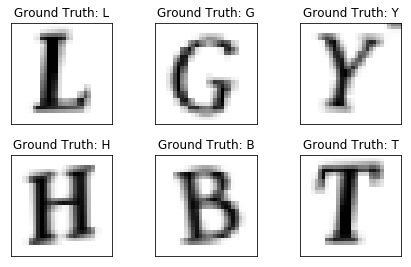

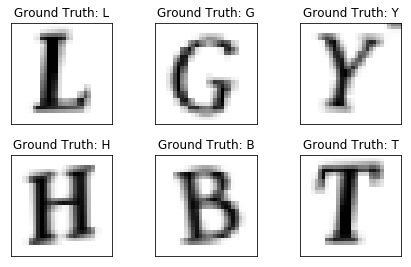

In [22]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(lb.inverse_transform(np.array(example_onehot))[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return F.log_softmax(x, dim=0)

In [ ]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
#        torch.save(net.state_dict(), 'model.pth')
#        torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
#test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    #test()

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()